# Representation Study - Distance Model
Extract and analyze internal representations from the dist_100k_1M_20epochs model

In [87]:
# Setup paths and imports
import sys
import os
from pathlib import Path

# Add parent directory to path for imports
notebook_dir = Path.cwd()
if notebook_dir.name == 'notebooks':
    project_root = notebook_dir.parent
else:
    project_root = Path('/n/home12/cfpark00/WM_1')
    
sys.path.insert(0, str(project_root))
print(f"Project root: {project_root}")

Project root: /n/holylfs06/LABS/finkbeiner_lab/Users/cfpark00/datadir/WM_1


In [88]:
# Import required libraries
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import yaml
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, Qwen2ForCausalLM
from typing import List, Dict, Tuple
import seaborn as sns

# Import project utilities
from src.utils import (
    load_cities_csv,
    haversine,
    parse_distance
)

print("Imports successful")

Imports successful


## Load Model and Config

In [89]:
# Load experiment config
config_path = '/n/home12/cfpark00/WM_1/outputs/experiments/dist_100k_1M_20epochs/config.yaml'
checkpoint_path=None
#config_path = '/n/home12/cfpark00/WM_1/outputs/experiments/rw200_100k_1m_20epochs_pt1/config.yaml'
#checkpoint_path='/n/home12/cfpark00/WM_1/outputs/experiments/rw200_100k_1m_20epochs_pt1/checkpoints/checkpoint-7816'
if checkpoint_path is None:
    experiment_name = config_path.split('/')[-2]  # Get experiment name from config path
    checkpoint_path = f'/n/home12/cfpark00/WM_1/outputs/experiments/{experiment_name}/checkpoints/final'
#
with open(config_path, 'r') as f:
    config = yaml.safe_load(f)

print("Config loaded:")
print(f"  Task type: {config['task_type']}")
print(f"  Model layers: {config['model']['num_hidden_layers']}")
print(f"  Hidden size: {config['model']['hidden_size']}")
print(f"  Attention heads: {config['model']['num_attention_heads']}")

Config loaded:
  Task type: distance
  Model layers: 6
  Hidden size: 128
  Attention heads: 4


In [90]:
# Load tokenizer
tokenizer_path = project_root / config['tokenizer_path']
tokenizer = AutoTokenizer.from_pretrained(str(tokenizer_path))
tokenizer.padding_side = 'left'  # For generation
print(f"Tokenizer loaded from {tokenizer_path}")
print(f"Vocab size: {len(tokenizer)}")

Tokenizer loaded from /n/holylfs06/LABS/finkbeiner_lab/Users/cfpark00/datadir/WM_1/outputs/tokenizer/wm1_tokenizer
Vocab size: 44


In [91]:
model = Qwen2ForCausalLM.from_pretrained(checkpoint_path)
model.eval()

# Move to GPU if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
print(f"Model loaded from {checkpoint_path}")
print(f"Using device: {device}")

Model loaded from /n/home12/cfpark00/WM_1/outputs/experiments/dist_100k_1M_20epochs/checkpoints/final
Using device: cuda


## Setup Hook for Representation Extraction

In [92]:
class RepresentationExtractor:
    """Extract representations from specific transformer layers"""
    
    def __init__(self, model, layer_indices=None):
        """
        Initialize the extractor.
        
        Args:
            model: The transformer model
            layer_indices: Either a single int or a list of ints specifying which layers to extract.
                          If None, defaults to layer 4 (index 3).
        """
        self.model = model
        
        # Handle both single index and list of indices
        if layer_indices is None:
            self.layer_indices = [3]  # Default to layer 4 (0-indexed)
        elif isinstance(layer_indices, int):
            self.layer_indices = [layer_indices]
        else:
            self.layer_indices = list(layer_indices)
        
        # Sort indices to ensure consistent ordering
        self.layer_indices = sorted(self.layer_indices)
        
        # Storage for representations from each layer
        self.representations = {}
        self.hook_handles = []
        
    def create_hook_fn(self, layer_idx):
        """Create a hook function for a specific layer"""
        def hook_fn(module, input, output):
            # output is a tuple (hidden_states, ...)
            # We want the hidden states after the layer (residual stream)
            hidden_states = output[0]  # Shape: (batch_size, seq_len, hidden_size)
            self.representations[layer_idx] = hidden_states.detach().cpu()
        return hook_fn
        
    def register_hooks(self):
        """Register forward hooks on all specified layers"""
        for layer_idx in self.layer_indices:
            # Access the specific transformer layer
            layer = self.model.model.layers[layer_idx]
            hook_fn = self.create_hook_fn(layer_idx)
            handle = layer.register_forward_hook(hook_fn)
            self.hook_handles.append(handle)
        
    def remove_hooks(self):
        """Remove all hooks"""
        for handle in self.hook_handles:
            handle.remove()
        self.hook_handles = []
            
    def extract(self, input_ids, attention_mask=None, concatenate=True):
        """
        Extract representations for given inputs.
        
        Args:
            input_ids: Input token IDs
            attention_mask: Attention mask
            concatenate: If True and multiple layers, concatenate representations.
                        If False, return dict mapping layer_idx to representations.
        
        Returns:
            If single layer: tensor of shape (batch_size, seq_len, hidden_size)
            If multiple layers and concatenate=True: tensor of shape (batch_size, seq_len, hidden_size * n_layers)
            If multiple layers and concatenate=False: dict mapping layer_idx to tensors
        """
        self.representations = {}
        self.register_hooks()
        
        with torch.no_grad():
            # Forward pass
            outputs = self.model(
                input_ids=input_ids,
                attention_mask=attention_mask,
                output_hidden_states=True
            )
        
        # Get the captured representations
        reps = {idx: self.representations[idx].clone() for idx in self.layer_indices}
        
        self.remove_hooks()
        
        # Return based on configuration
        if len(self.layer_indices) == 1:
            # Single layer - return tensor directly
            return reps[self.layer_indices[0]]
        elif concatenate:
            # Multiple layers - concatenate along hidden dimension
            concatenated = torch.cat([reps[idx] for idx in self.layer_indices], dim=-1)
            return concatenated
        else:
            # Multiple layers - return dictionary
            return reps
    
    @property
    def layer_idx(self):
        """Backward compatibility - return first layer index"""
        return self.layer_indices[0]
    
    def __repr__(self):
        if len(self.layer_indices) == 1:
            return f"RepresentationExtractor(layer={self.layer_indices[0]})"
        else:
            return f"RepresentationExtractor(layers={self.layer_indices})"

# Create extractor for layer 4 (0-indexed, so this is the 5th layer)
extractor = RepresentationExtractor(model, layer_indices=[3,4])
print(f"Representation extractor created: {extractor}")

Representation extractor created: RepresentationExtractor(layers=[3, 4])


## Load Cities Data

In [93]:
# Load cities data
# Need ../ because we're in notebooks/ directory
cities_df = load_cities_csv("../outputs/datasets/cities_100k_plus_seed42.csv")
print(f"Loaded {len(cities_df)} cities")
print("\nFirst few cities:")
print(cities_df[['row_id', 'asciiname', 'latitude', 'longitude', 'country_code']].head())

Loaded 5075 cities

First few cities:
   row_id   asciiname  latitude  longitude country_code
0       0    Culiacan  24.79032 -107.38782           MX
1       1        Beni   0.49113   29.47306           CD
2       2    Cileunyi  -6.93889  107.75278           ID
3       3   Wuppertal  51.25627    7.14816           DE
4       4  Lubumbashi -11.66089   27.47938           CD


## City Location Probe from Partial Prompts

In [99]:
# Select 1000 random cities without replacement
np.random.seed(42)  # Different seed for variety
n_cities_probe = 5000
n_train_cities = 3000

# Sample cities without replacement
sampled_city_indices = np.random.choice(len(cities_df), size=n_cities_probe, replace=False)
sampled_cities = cities_df.iloc[sampled_city_indices]

# Create partial prompts ending at "_" after "c_"
partial_prompts = []
city_info = []

for idx, city in sampled_cities.iterrows():
    # Create partial prompt: "dist(c_XXX,c_" (comma + c + underscore)
    # This fully disambiguates and starts the second city pattern
    prompt = f"<bos>dist(c_{city['row_id']},c_"
    #prompt = f"<bos>walk_200=c_{city['row_id']},c_"
    partial_prompts.append(prompt)
    city_info.append({
        'row_id': city['row_id'],
        'name': city['asciiname'],
        'longitude': city['longitude'],
        'latitude': city['latitude'],
        'country': city['country_code']
    })

print(f"Created {len(partial_prompts)} partial prompts")
print(f"Will use {n_train_cities} for training, {n_cities_probe - n_train_cities} for testing")
print("\nExample partial prompts (now with ',c_' for full disambiguation):")
for i in range(3):
    print(f"  '{partial_prompts[i]}' → {city_info[i]['name']} ({city_info[i]['longitude']:.2f}, {city_info[i]['latitude']:.2f})")

Created 5000 partial prompts
Will use 3000 for training, 2000 for testing

Example partial prompts (now with ',c_' for full disambiguation):
  '<bos>dist(c_1730,c_' → Apeldoorn (5.97, 52.21)
  '<bos>dist(c_2656,c_' → Sabzevar (57.68, 36.21)
  '<bos>dist(c_33,c_' → Paderborn (8.75, 51.72)


In [100]:
# Tokenize partial prompts with LEFT padding
tokenized_partial = tokenizer(
    partial_prompts,
    padding=True,
    truncation=True,
    return_tensors='pt'
)

partial_input_ids = tokenized_partial['input_ids'].to(device)
partial_attention_mask = tokenized_partial['attention_mask'].to(device)

print(f"Tokenized shape: {partial_input_ids.shape}")

# Extract representations at layer 4 for partial prompts
partial_representations = extractor.extract(partial_input_ids, partial_attention_mask)
print(f"Representations shape: {partial_representations.shape}")

# With left padding, all sequences end at the same position (rightmost)
# Now we have: ...c_XXX,c_] where the last three tokens are ",", "c", "_"
# Get representations from all three positions:
underscore_reps = partial_representations[:, -1, :]  # "_" (last token)
c_reps = partial_representations[:, -2, :]           # "c" 
comma_reps = partial_representations[:, -3, :]       # "," 

# Concatenate all three representations (128 * 3 = 384 dims)
partial_last_token_reps = torch.cat([comma_reps, c_reps, underscore_reps], dim=1)

print(f"Concatenated representations shape: {partial_last_token_reps.shape}")
print(f"  Comma ',' repr: {comma_reps.shape[1]} dims")
print(f"  Letter 'c' repr: {c_reps.shape[1]} dims")
print(f"  Underscore '_' repr: {underscore_reps.shape[1]} dims")
print(f"  Total: {partial_last_token_reps.shape[1]} dims")
print("\nThis captures the full transition sequence:")
print("  1. Comma ends first city ID")
print("  2. 'c' signals second city starts")
print("  3. '_' prepares for city ID digits")

Tokenized shape: torch.Size([5000, 15])
Representations shape: torch.Size([5000, 15, 256])
Concatenated representations shape: torch.Size([5000, 768])
  Comma ',' repr: 256 dims
  Letter 'c' repr: 256 dims
  Underscore '_' repr: 256 dims
  Total: 768 dims

This captures the full transition sequence:
  1. Comma ends first city ID
  2. 'c' signals second city starts
  3. '_' prepares for city ID digits


In [101]:
# Prepare data for coordinate prediction
partial_reps_np = partial_last_token_reps.cpu().numpy()

# Extract longitude and latitude as targets
longitudes = np.array([c['longitude'] for c in city_info])
latitudes = np.array([c['latitude'] for c in city_info])

# Split into train and test
X_train_coord = partial_reps_np[:n_train_cities]
X_test_coord = partial_reps_np[n_train_cities:]

lon_train = longitudes[:n_train_cities]
lon_test = longitudes[n_train_cities:]

lat_train = latitudes[:n_train_cities]
lat_test = latitudes[n_train_cities:]

print(f"Training set: {X_train_coord.shape[0]} cities")
print(f"Test set: {X_test_coord.shape[0]} cities")
print(f"\nCoordinate ranges:")
print(f"  Longitude: [{longitudes.min():.2f}, {longitudes.max():.2f}]")
print(f"  Latitude: [{latitudes.min():.2f}, {latitudes.max():.2f}]")

Training set: 3000 cities
Test set: 2000 cities

Coordinate ranges:
  Longitude: [-157.86, 176.17]
  Latitude: [-53.15, 69.35]


In [102]:
# Train linear probes for longitude and latitude
from sklearn.linear_model import Ridge

# Train longitude probe
lon_probe = Ridge(alpha=10.0)
lon_probe.fit(X_train_coord, lon_train)
lon_train_pred = lon_probe.predict(X_train_coord)
lon_test_pred = lon_probe.predict(X_test_coord)

# Train latitude probe
lat_probe = Ridge(alpha=10.0)
lat_probe.fit(X_train_coord, lat_train)
lat_train_pred = lat_probe.predict(X_train_coord)
lat_test_pred = lat_probe.predict(X_test_coord)

# Calculate metrics
from sklearn.metrics import mean_absolute_error, r2_score

lon_train_mae = mean_absolute_error(lon_train, lon_train_pred)
lon_test_mae = mean_absolute_error(lon_test, lon_test_pred)
lon_train_r2 = r2_score(lon_train, lon_train_pred)
lon_test_r2 = r2_score(lon_test, lon_test_pred)

lat_train_mae = mean_absolute_error(lat_train, lat_train_pred)
lat_test_mae = mean_absolute_error(lat_test, lat_test_pred)
lat_train_r2 = r2_score(lat_train, lat_train_pred)
lat_test_r2 = r2_score(lat_test, lat_test_pred)

print("Coordinate Prediction Results:")
print(f"\nLongitude:")
print(f"  Train MAE: {lon_train_mae:.2f}°, R²: {lon_train_r2:.3f}")
print(f"  Test MAE:  {lon_test_mae:.2f}°, R²: {lon_test_r2:.3f}")

print(f"\nLatitude:")
print(f"  Train MAE: {lat_train_mae:.2f}°, R²: {lat_train_r2:.3f}")
print(f"  Test MAE:  {lat_test_mae:.2f}°, R²: {lat_test_r2:.3f}")

# Calculate distance error in km using predicted coordinates
pred_distances_km = []
for i in range(len(lon_test_pred)):
    dist = haversine(lon_test[i], lat_test[i], lon_test_pred[i], lat_test_pred[i])
    pred_distances_km.append(dist)

mean_dist_error = np.mean(pred_distances_km)
median_dist_error = np.median(pred_distances_km)
print(f"\nLocation Error (test set):")
print(f"  Mean distance error: {mean_dist_error:.2f} km")
print(f"  Median distance error: {median_dist_error:.2f} km")

Coordinate Prediction Results:

Longitude:
  Train MAE: 5.75°, R²: 0.984
  Test MAE:  8.74°, R²: 0.956

Latitude:
  Train MAE: 2.60°, R²: 0.965
  Test MAE:  3.63°, R²: 0.923

Location Error (test set):
  Mean distance error: 992.78 km
  Median distance error: 678.96 km


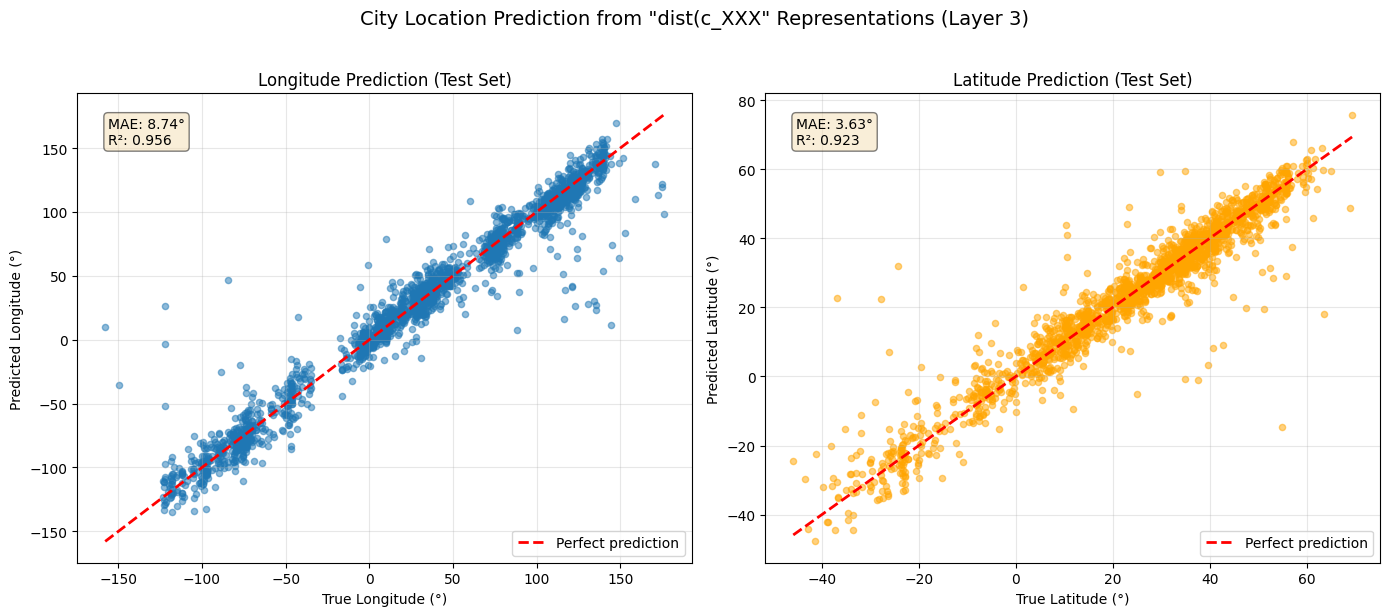


Interpretation:
The model encodes city location information in layer 3 representations.
From just 'dist(c_XXX', the model can predict:
  - Longitude with R² = 0.956
  - Latitude with R² = 0.923
  - Average location error: 993 km


In [103]:
# Visualize coordinate predictions
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Longitude scatter plot
axes[0].scatter(lon_test, lon_test_pred, alpha=0.5, s=20)
axes[0].plot([lon_test.min(), lon_test.max()], [lon_test.min(), lon_test.max()], 'r--', lw=2, label='Perfect prediction')
axes[0].set_xlabel('True Longitude (°)')
axes[0].set_ylabel('Predicted Longitude (°)')
axes[0].set_title(f'Longitude Prediction (Test Set)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)
axes[0].text(0.05, 0.95, f'MAE: {lon_test_mae:.2f}°\nR²: {lon_test_r2:.3f}',
            transform=axes[0].transAxes,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            verticalalignment='top')

# Latitude scatter plot
axes[1].scatter(lat_test, lat_test_pred, alpha=0.5, s=20, color='orange')
axes[1].plot([lat_test.min(), lat_test.max()], [lat_test.min(), lat_test.max()], 'r--', lw=2, label='Perfect prediction')
axes[1].set_xlabel('True Latitude (°)')
axes[1].set_ylabel('Predicted Latitude (°)')
axes[1].set_title(f'Latitude Prediction (Test Set)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
axes[1].text(0.05, 0.95, f'MAE: {lat_test_mae:.2f}°\nR²: {lat_test_r2:.3f}',
            transform=axes[1].transAxes,
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            verticalalignment='top')

plt.suptitle(f'City Location Prediction from "dist(c_XXX" Representations (Layer {extractor.layer_idx})', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

print(f"\nInterpretation:")
print(f"The model encodes city location information in layer {extractor.layer_idx} representations.")
print(f"From just 'dist(c_XXX', the model can predict:")
print(f"  - Longitude with R² = {lon_test_r2:.3f}")
print(f"  - Latitude with R² = {lat_test_r2:.3f}")
print(f"  - Average location error: {mean_dist_error:.0f} km")

In [104]:
# Create country code to continent mapping
country_to_continent = {
    # Africa
    'DZ': 'Africa', 'AO': 'Africa', 'BJ': 'Africa', 'BW': 'Africa', 'BF': 'Africa', 'BI': 'Africa',
    'CM': 'Africa', 'CV': 'Africa', 'CF': 'Africa', 'TD': 'Africa', 'KM': 'Africa', 'CG': 'Africa',
    'CD': 'Africa', 'CI': 'Africa', 'DJ': 'Africa', 'EG': 'Africa', 'GQ': 'Africa', 'ER': 'Africa',
    'ET': 'Africa', 'GA': 'Africa', 'GM': 'Africa', 'GH': 'Africa', 'GN': 'Africa', 'GW': 'Africa',
    'KE': 'Africa', 'LS': 'Africa', 'LR': 'Africa', 'LY': 'Africa', 'MG': 'Africa', 'MW': 'Africa',
    'ML': 'Africa', 'MR': 'Africa', 'MU': 'Africa', 'MA': 'Africa', 'MZ': 'Africa', 'NA': 'Africa',
    'NE': 'Africa', 'NG': 'Africa', 'RW': 'Africa', 'ST': 'Africa', 'SN': 'Africa', 'SC': 'Africa',
    'SL': 'Africa', 'SO': 'Africa', 'ZA': 'Africa', 'SS': 'Africa', 'SD': 'Africa', 'SZ': 'Africa',
    'TZ': 'Africa', 'TG': 'Africa', 'TN': 'Africa', 'UG': 'Africa', 'ZM': 'Africa', 'ZW': 'Africa',
    'EH': 'Africa',  # Western Sahara
    'RE': 'Africa',  # Réunion (French overseas department in Indian Ocean)
    
    # Asia
    'AF': 'Asia', 'AM': 'Asia', 'AZ': 'Asia', 'BH': 'Asia', 'BD': 'Asia', 'BT': 'Asia', 'BN': 'Asia',
    'KH': 'Asia', 'CN': 'Asia', 'CY': 'Asia', 'GE': 'Asia', 'IN': 'Asia', 'ID': 'Asia', 'IR': 'Asia',
    'IQ': 'Asia', 'IL': 'Asia', 'JP': 'Asia', 'JO': 'Asia', 'KZ': 'Asia', 'KW': 'Asia', 'KG': 'Asia',
    'LA': 'Asia', 'LB': 'Asia', 'MY': 'Asia', 'MV': 'Asia', 'MN': 'Asia', 'MM': 'Asia', 'NP': 'Asia',
    'KP': 'Asia', 'OM': 'Asia', 'PK': 'Asia', 'PS': 'Asia', 'PH': 'Asia', 'QA': 'Asia', 'SA': 'Asia',
    'SG': 'Asia', 'KR': 'Asia', 'LK': 'Asia', 'SY': 'Asia', 'TW': 'Asia', 'TJ': 'Asia', 'TH': 'Asia',
    'TL': 'Asia', 'TR': 'Asia', 'TM': 'Asia', 'AE': 'Asia', 'UZ': 'Asia', 'VN': 'Asia', 'YE': 'Asia',
    'HK': 'Asia', 'MO': 'Asia',
    
    # Europe
    'AL': 'Europe', 'AD': 'Europe', 'AT': 'Europe', 'BY': 'Europe', 'BE': 'Europe', 'BA': 'Europe',
    'BG': 'Europe', 'HR': 'Europe', 'CZ': 'Europe', 'DK': 'Europe', 'EE': 'Europe', 'FI': 'Europe',
    'FR': 'Europe', 'DE': 'Europe', 'GR': 'Europe', 'HU': 'Europe', 'IS': 'Europe', 'IE': 'Europe',
    'IT': 'Europe', 'XK': 'Europe', 'LV': 'Europe', 'LI': 'Europe', 'LT': 'Europe', 'LU': 'Europe',
    'MK': 'Europe', 'MT': 'Europe', 'MD': 'Europe', 'MC': 'Europe', 'ME': 'Europe', 'NL': 'Europe',
    'NO': 'Europe', 'PL': 'Europe', 'PT': 'Europe', 'RO': 'Europe', 'RU': 'Europe', 'SM': 'Europe',
    'RS': 'Europe', 'SK': 'Europe', 'SI': 'Europe', 'ES': 'Europe', 'SE': 'Europe', 'CH': 'Europe',
    'UA': 'Europe', 'GB': 'Europe', 'VA': 'Europe', 'GI': 'Europe', 'IM': 'Europe', 'JE': 'Europe',
    'GG': 'Europe', 'FO': 'Europe',
    
    # North America
    'AG': 'North America', 'BS': 'North America', 'BB': 'North America', 'BZ': 'North America',
    'CA': 'North America', 'CR': 'North America', 'CU': 'North America', 'DM': 'North America',
    'DO': 'North America', 'SV': 'North America', 'GD': 'North America', 'GT': 'North America',
    'HT': 'North America', 'HN': 'North America', 'JM': 'North America', 'MX': 'North America',
    'NI': 'North America', 'PA': 'North America', 'KN': 'North America', 'LC': 'North America',
    'VC': 'North America', 'TT': 'North America', 'US': 'North America', 'GL': 'North America',
    'BM': 'North America', 'KY': 'North America', 'TC': 'North America', 'VG': 'North America',
    'VI': 'North America', 'PR': 'North America', 'AW': 'North America', 'CW': 'North America',
    'SX': 'North America', 'BQ': 'North America', 'AI': 'North America', 'MQ': 'North America',
    'GP': 'North America', 'MS': 'North America', 'BL': 'North America', 'MF': 'North America',
    'PM': 'North America',
    
    # South America
    'AR': 'South America', 'BO': 'South America', 'BR': 'South America', 'CL': 'South America',
    'CO': 'South America', 'EC': 'South America', 'FK': 'South America', 'GF': 'South America',
    'GY': 'South America', 'PY': 'South America', 'PE': 'South America', 'SR': 'South America',
    'UY': 'South America', 'VE': 'South America',
    
    # Oceania
    'AU': 'Oceania', 'FJ': 'Oceania', 'KI': 'Oceania', 'MH': 'Oceania', 'FM': 'Oceania',
    'NR': 'Oceania', 'NZ': 'Oceania', 'PW': 'Oceania', 'PG': 'Oceania', 'WS': 'Oceania',
    'SB': 'Oceania', 'TO': 'Oceania', 'TV': 'Oceania', 'VU': 'Oceania', 'NC': 'Oceania',
    'PF': 'Oceania', 'GU': 'Oceania', 'AS': 'Oceania', 'MP': 'Oceania', 'CK': 'Oceania',
    'NU': 'Oceania', 'NF': 'Oceania', 'TK': 'Oceania', 'WF': 'Oceania', 'PN': 'Oceania',
    
    # Antarctica (unlikely to have cities, but included for completeness)
    'AQ': 'Antarctica'
}

In [105]:
# Get continents for test cities (last half of city_info)
test_city_info = city_info[n_train_cities:]  # The test portion of city_info
test_continents = []
unknown_cities = []  # Track unknown cities

for city in test_city_info:
    country = city['country']
    continent = country_to_continent.get(country, 'Unknown')
    test_continents.append(continent)
    
    # Track unknown cities
    if continent == 'Unknown':
        unknown_cities.append({
            'name': city['name'],
            'country': country,
            'row_id': city['row_id']
        })

# Count continents
from collections import Counter
continent_counts = Counter(test_continents)
print("Test cities by continent:")
for continent, count in sorted(continent_counts.items()):
    print(f"  {continent}: {count} cities")

# Print unknown cities
if unknown_cities:
    print(f"\nUnknown cities ({len(unknown_cities)}):")
    for city in unknown_cities:
        print(f"  - {city['name']} (Country code: '{city['country']}', row_id: {city['row_id']})")
    print("\nAdd these country codes to the mapping:")

Test cities by continent:
  Africa: 261 cities
  Asia: 917 cities
  Europe: 353 cities
  North America: 269 cities
  Oceania: 15 cities
  South America: 185 cities


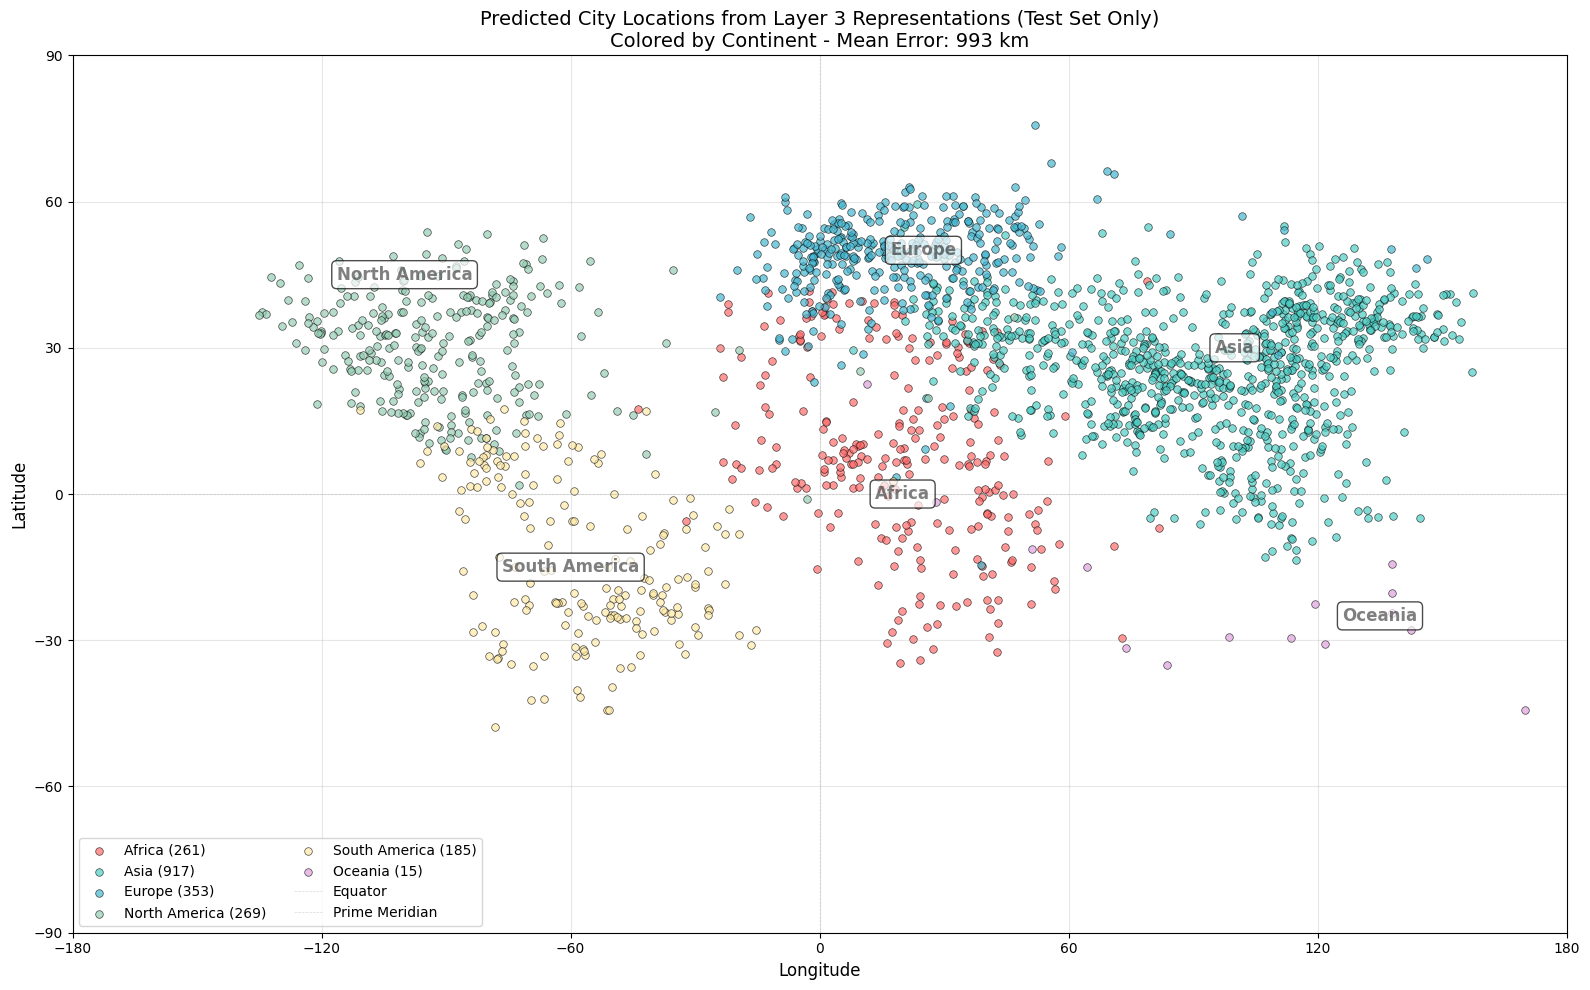


Predicted locations summary by continent:

Africa:
  Cities: 261
  Predicted center: (19.4°, 8.3°)
  True center: (17.3°, 7.1°)
  Mean location error: 1210 km

Asia:
  Cities: 917
  Predicted center: (93.1°, 26.2°)
  True center: (95.0°, 26.0°)
  Mean location error: 871 km

Europe:
  Cities: 353
  Predicted center: (20.6°, 48.6°)
  True center: (20.3°, 49.7°)
  Mean location error: 689 km

North America:
  Cities: 269
  Predicted center: (-90.5°, 30.4°)
  True center: (-94.6°, 31.2°)
  Mean location error: 1182 km

Oceania:
  Cities: 15
  Predicted center: (99.5°, -21.0°)
  True center: (153.3°, -34.8°)
  Mean location error: 5870 km

South America:
  Cities: 185
  Predicted center: (-57.5°, -13.0°)
  True center: (-57.4°, -13.6°)
  Mean location error: 1200 km


In [106]:
# Visualization of predicted locations colored by continent (no ground truth)
fig, ax = plt.subplots(1, 1, figsize=(16, 10))

# Define continent colors
continent_colors = {
    'Africa': '#FF6B6B',      # Red
    'Asia': '#4ECDC4',        # Teal
    'Europe': '#45B7D1',      # Blue
    'North America': '#96CEB4', # Green
    'South America': '#FFEAA7', # Yellow
    'Oceania': '#DDA0DD',     # Plum
    'Unknown': '#95A5A6',     # Gray
    'Antarctica': '#FFFFFF'    # White
}

# Plot predicted test locations by continent
for continent in continent_colors.keys():
    # Get indices for this continent
    continent_mask = [c == continent for c in test_continents]
    if sum(continent_mask) > 0:
        continent_lons = lon_test_pred[continent_mask]
        continent_lats = lat_test_pred[continent_mask]
        
        ax.scatter(continent_lons, continent_lats, 
                  s=30, alpha=0.7, c=continent_colors[continent],
                  label=f'{continent} ({sum(continent_mask)})', 
                  edgecolors='black', linewidth=0.5)

# Add grid and reference lines
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3, linewidth=0.5, label='Equator')
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3, linewidth=0.5, label='Prime Meridian')

# Add continent labels at approximate centers
continent_centers = {
    'Africa': (20, 0),
    'Asia': (100, 30),
    'Europe': (25, 50),
    'North America': (-100, 45),
    'South America': (-60, -15),
    'Oceania': (135, -25)
}

for continent, (lon, lat) in continent_centers.items():
    if continent in [c for c in test_continents]:  # Only label if we have cities from this continent
        ax.text(lon, lat, continent, fontsize=12, fontweight='bold', 
               ha='center', va='center', alpha=0.5,
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7))

ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title(f'Predicted City Locations from Layer {extractor.layer_idx} Representations (Test Set Only)\nColored by Continent - Mean Error: {mean_dist_error:.0f} km', 
            fontsize=14)
ax.legend(loc='lower left', ncol=2, fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)

# Add tick marks for better orientation
ax.set_xticks(range(-180, 181, 60))
ax.set_yticks(range(-90, 91, 30))

plt.tight_layout()
plt.show()

# Print summary statistics
print("\nPredicted locations summary by continent:")
for continent in sorted(set(test_continents)):
    if continent == 'Unknown':
        continue
    continent_mask = np.array([c == continent for c in test_continents])
    if continent_mask.sum() > 0:
        cont_lon_pred = lon_test_pred[continent_mask]
        cont_lat_pred = lat_test_pred[continent_mask]
        cont_lon_true = lon_test[continent_mask]
        cont_lat_true = lat_test[continent_mask]
        
        # Calculate mean error for this continent
        cont_distances = []
        for i in range(len(cont_lon_pred)):
            dist = haversine(cont_lon_true[i], cont_lat_true[i], 
                           cont_lon_pred[i], cont_lat_pred[i])
            cont_distances.append(dist)
        
        print(f"\n{continent}:")
        print(f"  Cities: {continent_mask.sum()}")
        print(f"  Predicted center: ({cont_lon_pred.mean():.1f}°, {cont_lat_pred.mean():.1f}°)")
        print(f"  True center: ({cont_lon_true.mean():.1f}°, {cont_lat_true.mean():.1f}°)")
        print(f"  Mean location error: {np.mean(cont_distances):.0f} km")

In [ ]:
# Create more granular country to region mapping
country_to_region = {
    # North America
    'US': 'North America', 'CA': 'North America', 'MX': 'North America', 'GT': 'North America',
    'BZ': 'North America', 'SV': 'North America', 'HN': 'North America', 'NI': 'North America',
    'CR': 'North America', 'PA': 'North America', 'CU': 'North America', 'HT': 'North America',
    'DO': 'North America', 'JM': 'North America', 'TT': 'North America', 'BB': 'North America',
    'BS': 'North America', 'AG': 'North America', 'DM': 'North America', 'GD': 'North America',
    'KN': 'North America', 'LC': 'North America', 'VC': 'North America', 'GL': 'North America',
    'BM': 'North America', 'KY': 'North America', 'TC': 'North America', 'VG': 'North America',
    'VI': 'North America', 'PR': 'North America', 'AW': 'North America', 'CW': 'North America',
    'SX': 'North America', 'BQ': 'North America', 'AI': 'North America', 'MQ': 'North America',
    'GP': 'North America', 'MS': 'North America', 'BL': 'North America', 'MF': 'North America',
    'PM': 'North America',
    
    # South America
    'BR': 'South America', 'AR': 'South America', 'CL': 'South America', 'PE': 'South America',
    'CO': 'South America', 'VE': 'South America', 'EC': 'South America', 'BO': 'South America',
    'PY': 'South America', 'UY': 'South America', 'GY': 'South America', 'SR': 'South America',
    'GF': 'South America', 'FK': 'South America',
    
    # Africa
    'ZA': 'Africa', 'EG': 'Africa', 'NG': 'Africa', 'ET': 'Africa', 'KE': 'Africa', 'UG': 'Africa',
    'DZ': 'Africa', 'SD': 'Africa', 'MA': 'Africa', 'AO': 'Africa', 'GH': 'Africa', 'MZ': 'Africa',
    'MG': 'Africa', 'CM': 'Africa', 'CI': 'Africa', 'NE': 'Africa', 'BF': 'Africa', 'ML': 'Africa',
    'MW': 'Africa', 'ZM': 'Africa', 'SN': 'Africa', 'SO': 'Africa', 'TD': 'Africa', 'ZW': 'Africa',
    'GN': 'Africa', 'RW': 'Africa', 'BJ': 'Africa', 'TN': 'Africa', 'BI': 'Africa', 'SS': 'Africa',
    'TG': 'Africa', 'SL': 'Africa', 'LY': 'Africa', 'LR': 'Africa', 'MR': 'Africa', 'CF': 'Africa',
    'ER': 'Africa', 'GM': 'Africa', 'GA': 'Africa', 'BW': 'Africa', 'NA': 'Africa', 'MU': 'Africa',
    'SZ': 'Africa', 'GQ': 'Africa', 'DJ': 'Africa', 'KM': 'Africa', 'CV': 'Africa', 'ST': 'Africa',
    'SC': 'Africa', 'LS': 'Africa', 'GW': 'Africa', 'TZ': 'Africa', 'CG': 'Africa', 'CD': 'Africa',
    'EH': 'Africa', 'RE': 'Africa',
    
    # Western Europe (including Central Europe)
    'GB': 'Western Europe', 'FR': 'Western Europe', 'DE': 'Western Europe', 'IT': 'Western Europe', 
    'ES': 'Western Europe', 'NL': 'Western Europe', 'BE': 'Western Europe', 'PT': 'Western Europe',
    'CH': 'Western Europe', 'AT': 'Western Europe', 'IE': 'Western Europe', 'DK': 'Western Europe',
    'SE': 'Western Europe', 'NO': 'Western Europe', 'FI': 'Western Europe', 'IS': 'Western Europe',
    'LU': 'Western Europe', 'MC': 'Western Europe', 'LI': 'Western Europe', 'SM': 'Western Europe',
    'VA': 'Western Europe', 'AD': 'Western Europe', 'MT': 'Western Europe', 'GI': 'Western Europe',
    'JE': 'Western Europe', 'GG': 'Western Europe', 'IM': 'Western Europe', 'FO': 'Western Europe',
    
    # Eastern Europe (including Russia, Balkans, and former Soviet states)
    'RU': 'Eastern Europe', 'UA': 'Eastern Europe', 'PL': 'Eastern Europe', 'RO': 'Eastern Europe',
    'CZ': 'Eastern Europe', 'HU': 'Eastern Europe', 'BY': 'Eastern Europe', 'BG': 'Eastern Europe',
    'SK': 'Eastern Europe', 'RS': 'Eastern Europe', 'HR': 'Eastern Europe', 'BA': 'Eastern Europe',
    'AL': 'Eastern Europe', 'LT': 'Eastern Europe', 'LV': 'Eastern Europe', 'EE': 'Eastern Europe',
    'MD': 'Eastern Europe', 'SI': 'Eastern Europe', 'MK': 'Eastern Europe', 'ME': 'Eastern Europe',
    'XK': 'Eastern Europe', 'GR': 'Eastern Europe',  # Greece could go either way
    
    # Middle East
    'TR': 'Middle East', 'IR': 'Middle East', 'SA': 'Middle East', 'YE': 'Middle East', 'IQ': 'Middle East',
    'SY': 'Middle East', 'AE': 'Middle East', 'IL': 'Middle East', 'JO': 'Middle East', 'LB': 'Middle East',
    'OM': 'Middle East', 'PS': 'Middle East', 'KW': 'Middle East', 'QA': 'Middle East', 'BH': 'Middle East',
    'CY': 'Middle East', 'GE': 'Middle East', 'AM': 'Middle East', 'AZ': 'Middle East',
    
    # India (Indian subcontinent)
    'IN': 'India', 'PK': 'India', 'BD': 'India', 'LK': 'India', 'NP': 'India', 'BT': 'India',
    'MV': 'India', 'AF': 'India',  # Afghanistan often grouped with South Asia
    
    # China (Greater China region)
    'CN': 'China', 'TW': 'China', 'HK': 'China', 'MO': 'China',
    
    # Korea
    'KR': 'Korea', 'KP': 'Korea',
    
    # Japan
    'JP': 'Japan',
    
    # Southeast Asia
    'ID': 'Southeast Asia', 'TH': 'Southeast Asia', 'MY': 'Southeast Asia', 'VN': 'Southeast Asia',
    'PH': 'Southeast Asia', 'SG': 'Southeast Asia', 'MM': 'Southeast Asia', 'KH': 'Southeast Asia',
    'LA': 'Southeast Asia', 'TL': 'Southeast Asia', 'BN': 'Southeast Asia',
    
    # Central Asia (the -stan countries + Mongolia)
    'KZ': 'Central Asia', 'UZ': 'Central Asia', 'TM': 'Central Asia', 'TJ': 'Central Asia',
    'KG': 'Central Asia', 'MN': 'Central Asia',
    
    # Oceania
    'AU': 'Oceania', 'NZ': 'Oceania', 'PG': 'Oceania', 'FJ': 'Oceania', 'SB': 'Oceania',
    'NC': 'Oceania', 'PF': 'Oceania', 'VU': 'Oceania', 'WS': 'Oceania', 'KI': 'Oceania',
    'TO': 'Oceania', 'FM': 'Oceania', 'PW': 'Oceania', 'MH': 'Oceania', 'TV': 'Oceania',
    'NR': 'Oceania', 'GU': 'Oceania', 'MP': 'Oceania', 'AS': 'Oceania', 'CK': 'Oceania',
    'NU': 'Oceania', 'TK': 'Oceania', 'NF': 'Oceania', 'PN': 'Oceania', 'WF': 'Oceania',
    
    # Antarctica
    'AQ': 'Antarctica'
}


Test cities by region:
  Africa: 261 cities
  Central Asia: 22 cities
  China: 242 cities
  Eastern Europe: 170 cities
  India: 245 cities
  Japan: 82 cities
  Korea: 26 cities
  Middle East: 130 cities
  North America: 269 cities
  Oceania: 15 cities
  South America: 185 cities
  Southeast Asia: 170 cities
  Western Europe: 183 cities

Target regions coverage:
  North America: 269 cities
  South America: 185 cities
  Africa: 261 cities
  Western Europe: 183 cities
  Eastern Europe: 170 cities
  Middle East: 130 cities
  India: 245 cities
  China: 242 cities
  Korea: 26 cities
  Japan: 82 cities
  Southeast Asia: 170 cities
  Oceania: 15 cities

Note: 
  - Western Europe: UK, France, Germany, Italy, Spain, Nordics, etc.
  - Eastern Europe: Russia, Poland, Ukraine, Balkans, Baltic states, etc.
  - Central Asia: Kazakhstan, Uzbekistan, Turkmenistan, Tajikistan, Kyrgyzstan, Mongolia


In [ ]:

# Get regions for test cities
test_regions = []
for city in test_city_info:
    country = city['country']
    region = country_to_region.get(country, 'Unknown')
    test_regions.append(region)

# Count regions
from collections import Counter
region_counts = Counter(test_regions)
print("Test cities by region:")
for region, count in sorted(region_counts.items()):
    if count > 0:
        print(f"  {region}: {count} cities")

# Check for any remaining unknown
unknown_regions = [city for city, region in zip(test_city_info, test_regions) if region == 'Unknown']
if unknown_regions:
    print(f"\nStill unknown ({len(unknown_regions)}):")
    for city in unknown_regions:
        print(f"  - {city['name']} (Country: '{city['country']}')")
        
# Summary of main target regions
target_regions = ['North America', 'South America', 'Africa', 'Western Europe', 'Eastern Europe', 
                  'Middle East', 'India', 'China', 'Korea', 'Japan', 'Southeast Asia', 'Oceania']
print(f"\nTarget regions coverage:")
for region in target_regions:
    count = region_counts.get(region, 0)
    print(f"  {region}: {count} cities")
    
print(f"\nNote: ")
print(f"  - Western Europe: UK, France, Germany, Italy, Spain, Nordics, etc.")
print(f"  - Eastern Europe: Russia, Poland, Ukraine, Balkans, Baltic states, etc.")
print(f"  - Central Asia: Kazakhstan, Uzbekistan, Turkmenistan, Tajikistan, Kyrgyzstan, Mongolia")

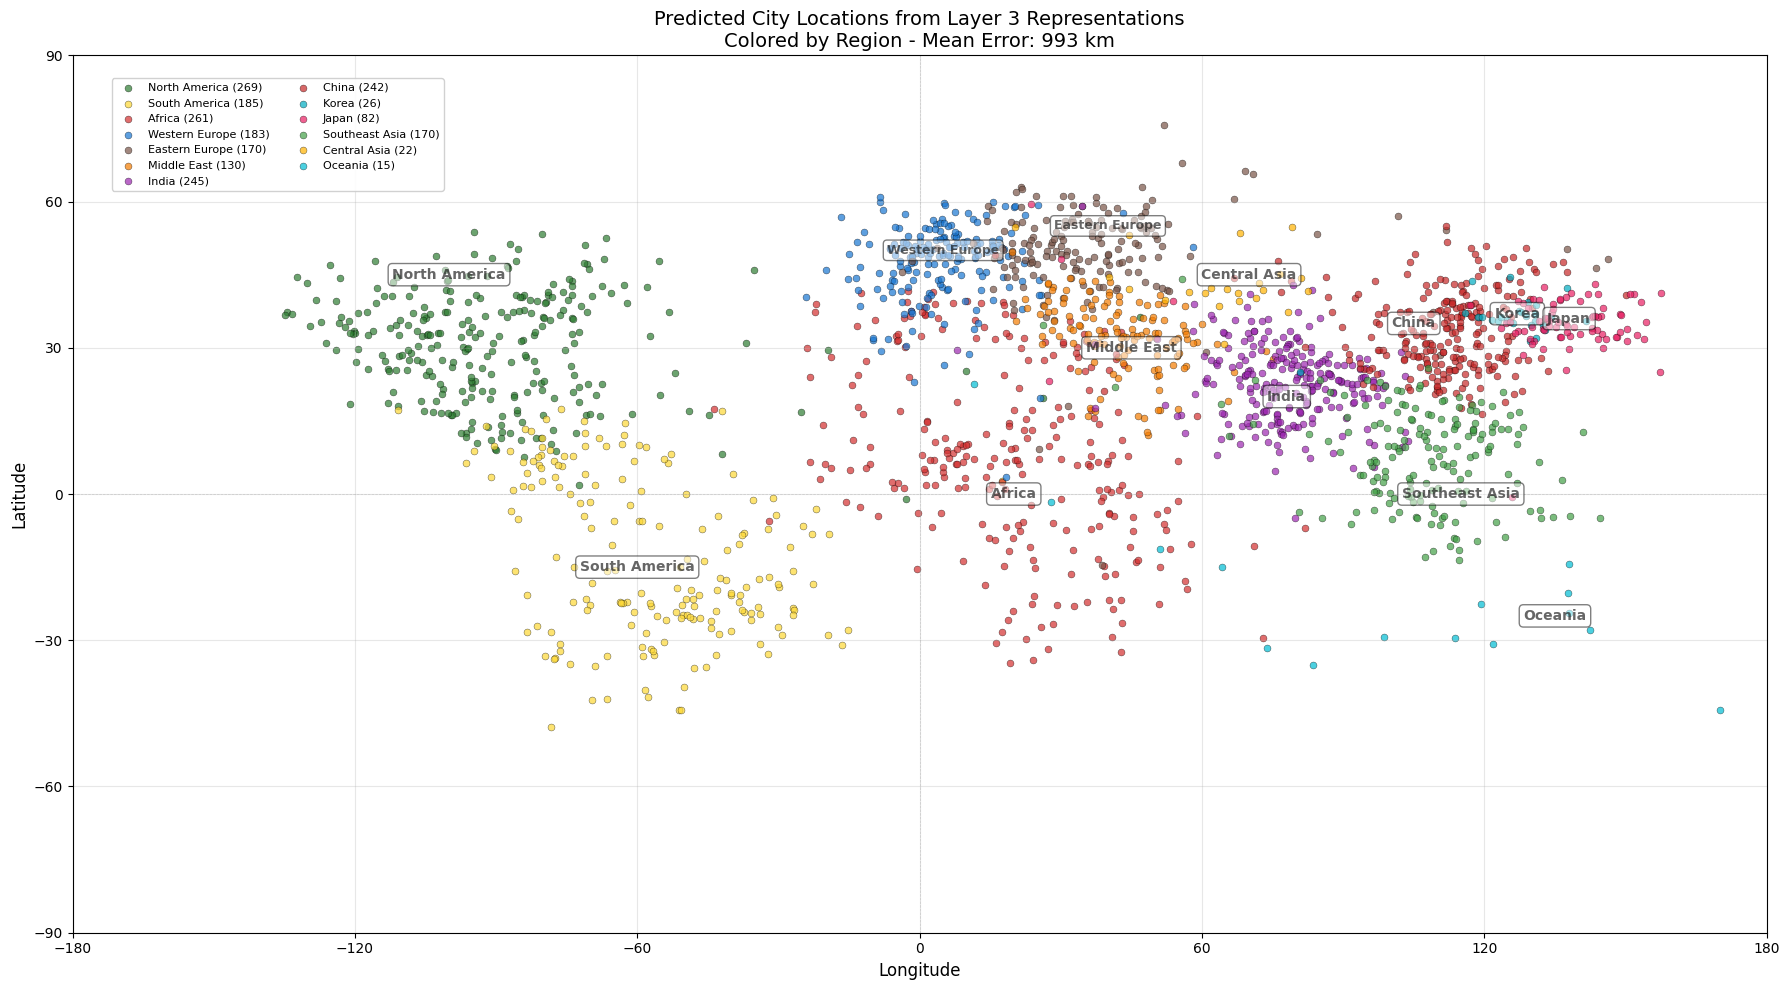

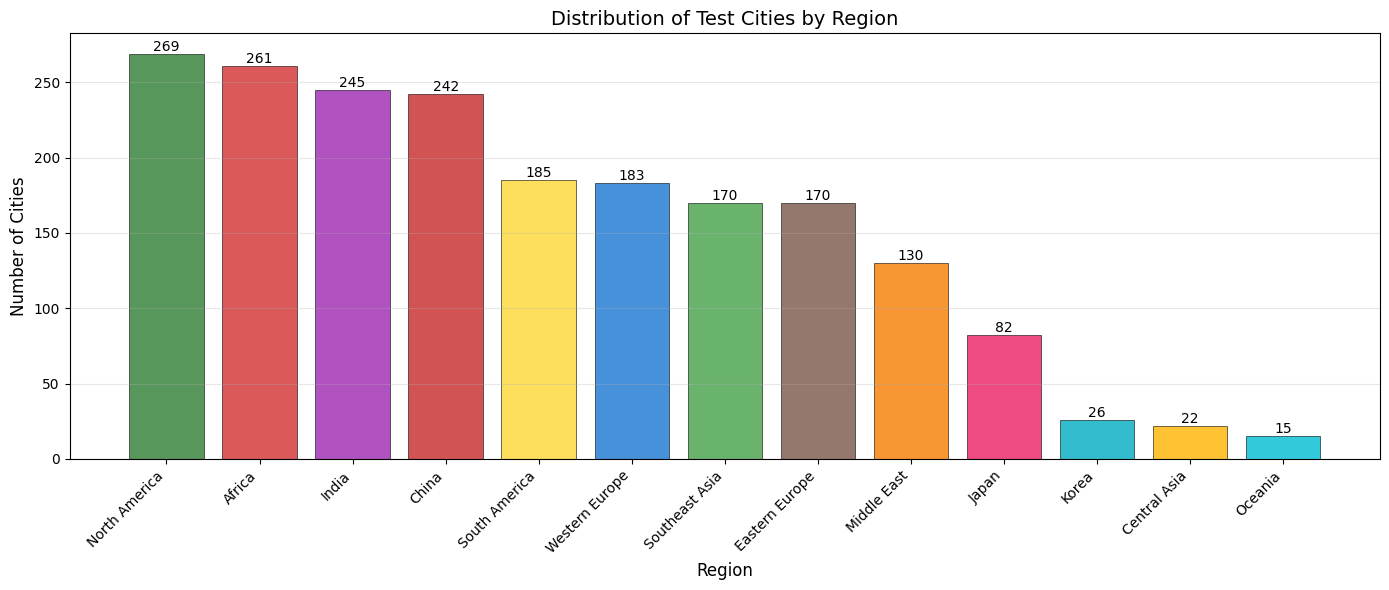


Prediction accuracy by region:

Africa (261 cities):
  Mean location error: 1210 km
  Median location error: 899 km
  Std dev: 1049 km

Central Asia (22 cities):
  Mean location error: 822 km
  Median location error: 680 km
  Std dev: 566 km

China (242 cities):
  Mean location error: 736 km
  Median location error: 550 km
  Std dev: 923 km

Eastern Europe (170 cities):
  Mean location error: 747 km
  Median location error: 533 km
  Std dev: 964 km

India (245 cities):
  Mean location error: 869 km
  Median location error: 633 km
  Std dev: 892 km

Japan (82 cities):
  Mean location error: 1107 km
  Median location error: 583 km
  Std dev: 1756 km

Korea (26 cities):
  Mean location error: 704 km
  Median location error: 536 km
  Std dev: 834 km

Middle East (130 cities):
  Mean location error: 705 km
  Median location error: 583 km
  Std dev: 503 km

North America (269 cities):
  Mean location error: 1182 km
  Median location error: 792 km
  Std dev: 1683 km

Oceania (15 cities):
  M

In [108]:
# Visualization of predicted locations colored by region
fig, ax = plt.subplots(1, 1, figsize=(18, 10))

# Define region colors - using distinct colors for each region
region_colors = {
    'North America': '#2E7D32',     # Dark Green
    'South America': '#FDD835',     # Yellow  
    'Africa': '#D32F2F',           # Red
    'Western Europe': '#1976D2',    # Blue
    'Eastern Europe': '#795548',    # Brown
    'Middle East': '#F57C00',      # Orange
    'India': '#9C27B0',            # Purple
    'China': '#C62828',            # Dark Red
    'Korea': '#00ACC1',            # Cyan
    'Japan': '#E91E63',            # Pink
    'Southeast Asia': '#43A047',   # Light Green
    'Central Asia': '#FFB300',     # Amber (changed from Blue Grey)
    'Oceania': '#00BCD4',          # Light Cyan
    'Unknown': '#9E9E9E',          # Gray
}

# Plot predicted test locations by region
for region in region_colors.keys():
    # Get indices for this region
    region_mask = [r == region for r in test_regions]
    if sum(region_mask) > 0:
        region_lons = lon_test_pred[region_mask]
        region_lats = lat_test_pred[region_mask]
        
        ax.scatter(region_lons, region_lats, 
                  s=25, alpha=0.7, c=region_colors[region],
                  label=f'{region} ({sum(region_mask)})', 
                  edgecolors='black', linewidth=0.3)

# Add grid and reference lines
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)  # Equator
ax.axvline(x=0, color='gray', linestyle='--', alpha=0.3, linewidth=0.5)  # Prime Meridian

# Add region labels at approximate centers
region_label_positions = {
    'North America': (-100, 45),
    'South America': (-60, -15),
    'Africa': (20, 0),
    'Western Europe': (5, 50),     # Shifted west
    'Eastern Europe': (40, 55),    # Shifted east  
    'Middle East': (45, 30),
    'India': (78, 20),
    'China': (105, 35),
    'Korea': (127, 37),
    'Japan': (138, 36),
    'Southeast Asia': (115, 0),
    'Central Asia': (70, 45),
    'Oceania': (135, -25)
}

for region, (lon, lat) in region_label_positions.items():
    if region in test_regions:  # Only label if we have cities from this region
        # Adjust font size for longer labels
        fontsize = 9 if 'Europe' in region else 10
        ax.text(lon, lat, region, fontsize=fontsize, fontweight='bold', 
               ha='center', va='center', alpha=0.6,
               bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.5))

ax.set_xlabel('Longitude', fontsize=12)
ax.set_ylabel('Latitude', fontsize=12)
ax.set_title(f'Predicted City Locations from Layer {extractor.layer_idx} Representations\nColored by Region - Mean Error: {mean_dist_error:.0f} km', 
            fontsize=14)

# Create a more compact legend
ax.legend(loc='upper left', ncol=2, fontsize=8, 
         bbox_to_anchor=(0.02, 0.98), framealpha=0.9)

ax.grid(True, alpha=0.3)
ax.set_xlim(-180, 180)
ax.set_ylim(-90, 90)

# Add tick marks for better orientation
ax.set_xticks(range(-180, 181, 60))
ax.set_yticks(range(-90, 91, 30))

plt.tight_layout()
plt.show()

# Create a bar chart showing distribution of cities by region
fig2, ax2 = plt.subplots(1, 1, figsize=(14, 6))

# Sort regions by count for better visualization
sorted_regions = sorted([(region, count) for region, count in region_counts.items() 
                        if count > 0 and region != 'Unknown'], 
                       key=lambda x: x[1], reverse=True)

regions = [r[0] for r in sorted_regions]
counts = [r[1] for r in sorted_regions]
colors = [region_colors.get(r, '#9E9E9E') for r in regions]

bars = ax2.bar(regions, counts, color=colors, edgecolor='black', linewidth=0.5, alpha=0.8)

# Add value labels on bars
for bar, count in zip(bars, counts):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
            f'{count}', ha='center', va='bottom', fontsize=10)

ax2.set_xlabel('Region', fontsize=12)
ax2.set_ylabel('Number of Cities', fontsize=12)
ax2.set_title('Distribution of Test Cities by Region', fontsize=14)
ax2.grid(True, alpha=0.3, axis='y')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Print accuracy by region
print("\nPrediction accuracy by region:")
for region in sorted(set(test_regions)):
    if region == 'Unknown':
        continue
    region_mask = np.array([r == region for r in test_regions])
    if region_mask.sum() > 5:  # Only show regions with >5 cities
        reg_lon_pred = lon_test_pred[region_mask]
        reg_lat_pred = lat_test_pred[region_mask]
        reg_lon_true = lon_test[region_mask]
        reg_lat_true = lat_test[region_mask]
        
        # Calculate mean error for this region
        reg_distances = []
        for i in range(len(reg_lon_pred)):
            dist = haversine(reg_lon_true[i], reg_lat_true[i], 
                           reg_lon_pred[i], reg_lat_pred[i])
            reg_distances.append(dist)
        
        print(f"\n{region} ({region_mask.sum()} cities):")
        print(f"  Mean location error: {np.mean(reg_distances):.0f} km")
        print(f"  Median location error: {np.median(reg_distances):.0f} km")
        print(f"  Std dev: {np.std(reg_distances):.0f} km")